In [1]:
import os
import json
from collections import namedtuple
import matplotlib.pyplot as plt
import numpy as np

from time import time

import torch
from torch.utils.data import DataLoader

baseDir = '/home/hoehlein/PycharmProjects/grib_windfields'
os.chdir(baseDir)

from GUI.GraphCreator import createVectorGraph
from DataPreprocessing.DataScaler import DataScaler
from DataPreprocessing import DataLoader as dl
from Networks.CondVAE import *
from Utils.PlotsCondVAE import FieldViewer

In [17]:
netName = 'MinimalNet'
runNumber = 69
epoch = 120

runName = 'run_{:05d}'.format(runNumber)

runDir = '{}/results/{}/records/{}'.format(baseDir, netName, runName)

with open(os.path.join(runDir, 'config.json'), 'r') as f:
    configOptions = json.load(f)
    
configOptions['training'].update({'batchSize': 100})

logDir = configOptions['debugging']['recordDir']
directories = {'results': os.path.join(logDir, netName),
               'records': os.path.join(logDir, netName, 'records'),
               'models':  os.path.join(logDir, netName, 'records', 'models'),
               'data': {'training': configOptions['preprocess']['pathTraining'],
                        'test':     configOptions['preprocess']['pathTest'],
                        'raw':      configOptions['preprocess']['pathRaw']}
              }
directories.update({'currentRun': os.path.join(directories['records'], runName)})
directories.update({'models': os.path.join(directories['currentRun'], 'models')})
    
dataOpt = dl.dataSettings('input', 'input_orography', configOptions['data']['gridsInput'],
                          'target', 'target_orography', configOptions['data']['gridsTarget'])

valiOpt = dl.validationSettings(configOptions['data']['validationMode'],
                                configOptions['data']['validationInput'],
                                configOptions['data']['validationRegions'])

patchMode = configOptions['preprocess']['patchSize'] if configOptions['preprocess']['patching'] else None
trainingOpt = dl.trainingSettings(configOptions['preprocess']['monthsTraining'],
                                  patchMode, configOptions['data']['useHROrography'],
                                  configOptions['preprocess']['trainingRegions'])
scaleDict = torch.load(os.path.join(directories['models'], 'scaling.pth'))
scaleOpt = dl.scalingSettings(*[scaleDict[key] for key in scaleDict.keys()])

tempOpt = dl.temporalSettings(configOptions['data']['numStepsPast'], 1, configOptions['data']['numStepsFuture'], 1)

dataLoader = dl.DataLoader(directories['data']['training'],
                           configOptions['data']['maxNumFiles'],
                           dataOpt, trainingOpt, scaleOpt, valiOpt, tempOpt)
dataTraining, dataValidation = dataLoader.loadDataForTraining()

# create loaders for PyTorch with pre-defined batch size
trainLoader = DataLoader(dataTraining, batch_size=configOptions['training']['batchSize'],
                         shuffle=True, drop_last=True, num_workers=0)

validationLoader = DataLoader(dataValidation, batch_size=configOptions['training']['batchSize'],
                              shuffle=False, drop_last=True, num_workers=0)

# modelDict = torch.load(os.path.join(directories['models'], '{}_Temporal_epoch_{}.pth'.format(netName, epoch)))

# scalerUV = modelDict['scalingsInput'][0][0]
# scalerLSM = modelDict['scalingsInput'][1][0]
# scalerZ = modelDict['scalingsInput'][2][0]
# scalerBLH = modelDict['scalingsInput'][3][0]
# scalerFSR = modelDict['scalingsInput'][4][0]
# scalerUVHR = modelDict['scalingsTarget'][0][0]

# net = modelDict['model']

print(os.getcwd())

[INFO]: Process data file <data/training/alps/ERA5_predictand_vars_area1_2017_packed_padded.npz>
[INFO]: Load used grids into RAM
Progress: |=========>....................| 34% (3000/8767)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Progress: |==============================| 100% (8767/8767)
[INFO]: Process data file <data/training/alps/ERA5_predictand_vars_area1_2018_packed_padded.npz>
[INFO]: Load used grids into RAM
Progress: |=========>....................| 34% (3000/8760)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Progress: |==============================| 100% (8760/8760)
[INFO]: Process data file <data/training/alps/HRES_100m_wind_cpts_area1_2017_packed_padded.npz>
[INFO]: Load used grids into RAM
Progress: |=========>....................| 34% (3000/8767)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Progress: |==============================| 100% (8767/8767)
[INFO]: Process data file <data/training/alps/HRES_100m_wind_cpts_area1_2018_packed_padded.npz>
[INFO]: Load used grids into RAM
Progress: |=========>....................| 34% (3000/8760)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Progress: |==============================| 100% (8760/8760)
46.78052020072937
[INFO]: Normalize input and output channels
[INFO]: Create training and validation data
[INFO]: Number of training files: 8760
[INFO]: Number of validation files: 8760
/home/hoehlein/PycharmProjects/grib_windfields


In [3]:
cudaAvailable = torch.cuda.is_available()
device = torch.device("cuda:0" if cudaAvailable else "cpu")
trainData = next(iter(trainLoader))
inputs_cpu, targets_cpu, gridLR, gridHR, maskLR, maskHR, hrOro, idx = trainData
targets = tuple([data.to(device) for data in targets_cpu])
hrOro = hrOro.to(device)
inputs = targets[:-1]
previous = tuple([scalerUVHR.transform_back(data) for data in inputs]) 
targets = scalerUVHR.transform_back(targets[-1])
# print('After data upload...')
# time.sleep(5)
# zero out the parameters of the gradients
if netName == 'RecursiveNet':
    if configOptions['data']['useHROrography']:
        inputs = tuple([torch.cat((input, hrOro), dim=1) for input in inputs])
else:
    if configOptions['data']['useHROrography']:
        inputs = torch.cat(inputs + (hrOro,), dim=1)
    else:
        inputs = torch.cat(inputs, dim=1)
predictions = net(inputs)

In [4]:
fvHR = FieldViewer(gridHR, maskHR)

[INFO] Processing 3D data array.
[INFO] Found padded vector field.
[INFO] Processing 3D data array.
[INFO] Found padded vector field.
[INFO] Processing 3D data array.
[INFO] Found padded vector field.
[INFO] Processing 4D data array.
[INFO] Found padded ensemble of vector fields.


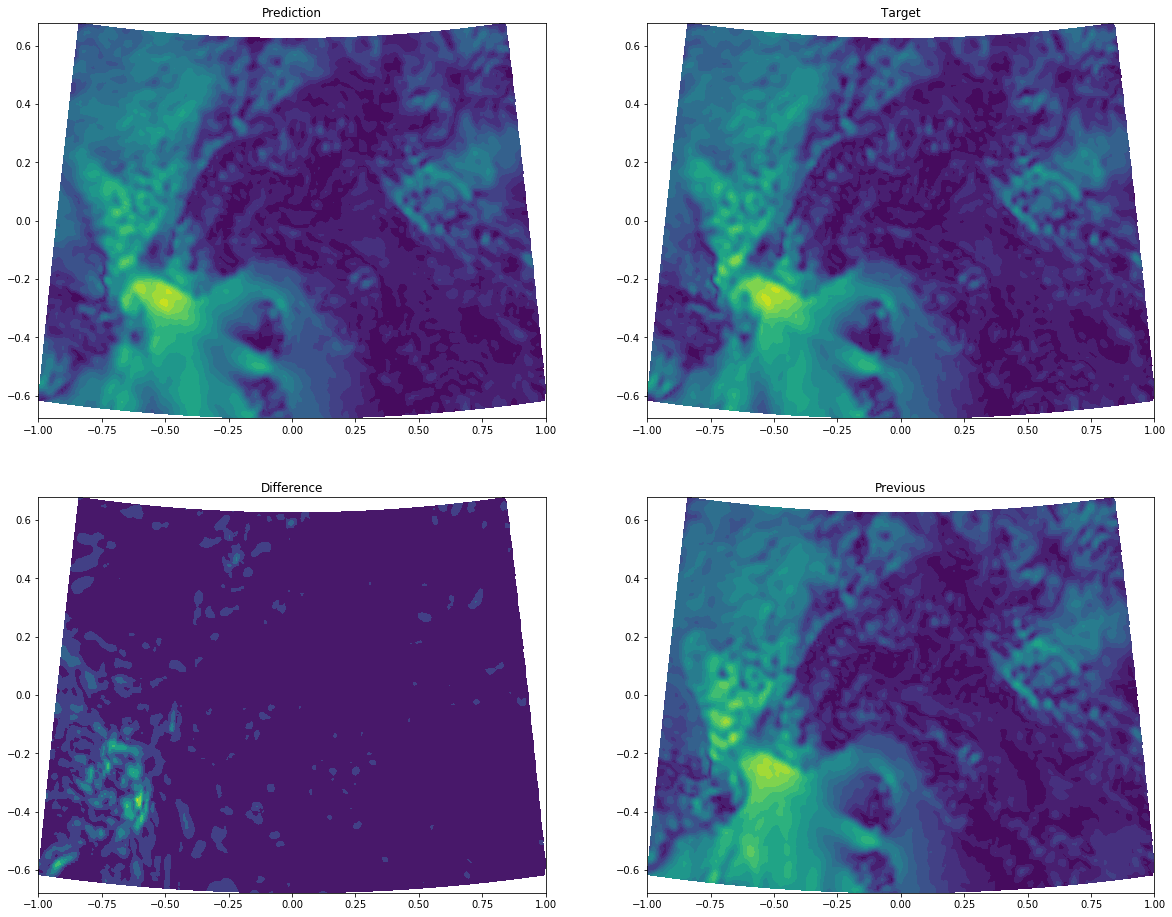

In [5]:
fig, ax = plt.subplots(2, 2, figsize=(20,16))
ax[0,0].set_title('Prediction')
fvHR.plot_scalar(data=predictions[0], transform='norm', levels = np.arange(19), axis=ax[0,0])
ax[0,1].set_title('Target')
fvHR.plot_scalar(data=targets[0], transform='norm', levels = np.arange(19), axis=ax[0,1])
ax[1,0].set_title('Difference')
fvHR.plot_scalar(data=predictions[0]-targets[0], transform='norm', axis=ax[1,0])
ax[1,1].set_title('Previous')
fvHR.plot_scalar(data=previous[0], transform='norm', levels = np.arange(19), axis=ax[1,1])

[INFO] Processing 3D data array.
[INFO] Found padded scalar field.
[INFO] Processing 3D data array.
[INFO] Found padded scalar field.


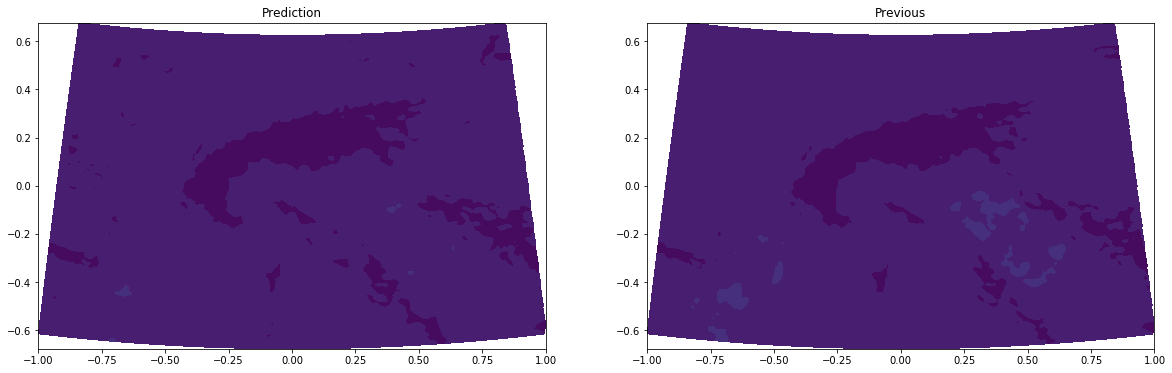

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(20,6))
ax[0].set_title('Prediction')
fvHR.plot_scalar(data=torch.abs(predictions-targets).sum(dim=1, keepdims=True).mean(dim=0), transform='norm', levels = np.arange(19), axis=ax[0])
ax[1].set_title('Previous')
fvHR.plot_scalar(data=torch.abs(previous[-1]-targets).sum(dim=1, keepdims=True).mean(dim=0), transform='norm', levels = np.arange(19), axis=ax[1])

In [37]:
torch.abs(previous[-1]-targets).sum(dim=1, keepdims=True).mean()

tensor(1.3567, device='cuda:0')

In [38]:
torch.abs(previous[-2]-previous[-1]).sum(dim=1, keepdims=True).mean()

tensor(1.4048, device='cuda:0')

In [39]:
torch.abs(previous[-3]-previous[-2]).sum(dim=1, keepdims=True).mean()

tensor(1.3160, device='cuda:0')

In [8]:
torch.abs(predictions-targets).sum(dim=1, keepdims=True).mean()

tensor(1.2327, device='cuda:0', grad_fn=<MeanBackward0>)

In [41]:
torch.abs(3 * previous[-1] - 3 * previous[-2] + previous[-3] - targets).sum(dim=1, keepdims=True).mean()

tensor(2.7661, device='cuda:0')

In [26]:
torch.abs((previous[0] + previous[2])/2 - previous[1]).sum(dim=1, keepdims=True).mean()

tensor(0.8297, device='cuda:0')

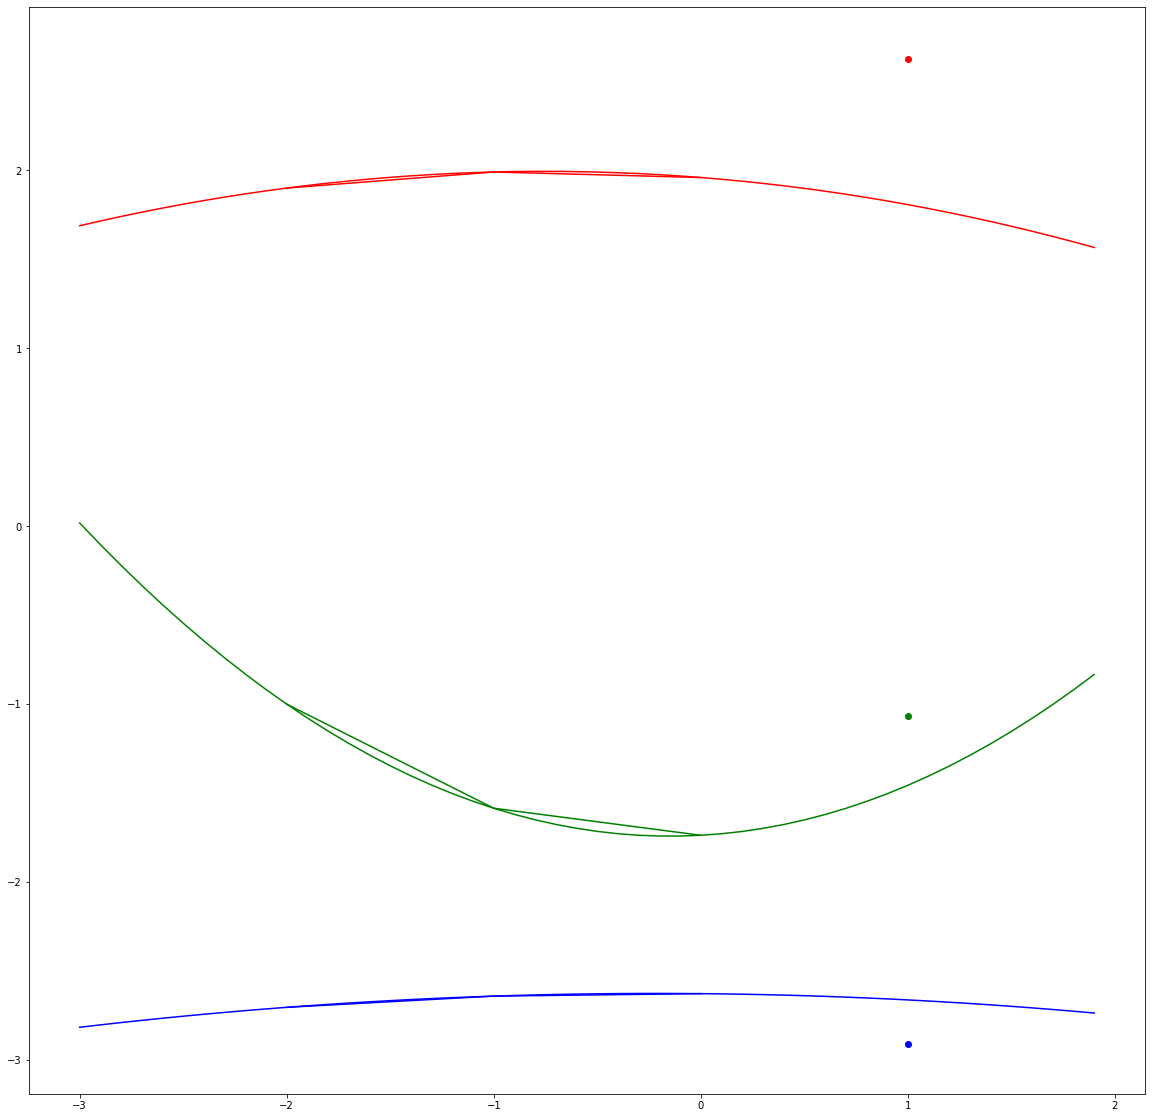

In [36]:
plt.figure(figsize=(20,20))
colors = ['blue', 'red', 'green']
for i in range(3):
    idx1 = np.random.randint(144)
    idx2 = np.random.randint(180)
    f = np.array([data[0,0,idx1,idx2].cpu().data.numpy() for data in previous])
    t = targets[0,0,idx1,idx2].cpu().data.numpy()
    x = np.array([-2,-1,0])
    x_fit = np.arange(-3,2,0.1)
    m = np.array([[1, -2, 4], [1, -1, 1], [1, 0, 0]])
    c = np.linalg.solve(m,f)
    f_fit = c[0] + c[1] * x_fit + c[2] * x_fit**2
    plt.plot(x,f, colors[i])
    plt.plot(x_fit, f_fit, colors[i])
    plt.scatter(1, t, c = colors[i])

[[ 1 -2  4 -8]
 [ 1 -1  1 -1]
 [ 1  1  1  1]
 [ 1  2  4  8]]
[[ 1 -2  4 -8]
 [ 1 -1  1 -1]
 [ 1  1  1  1]
 [ 1  2  4  8]]
[[ 1 -2  4 -8]
 [ 1 -1  1 -1]
 [ 1  1  1  1]
 [ 1  2  4  8]]


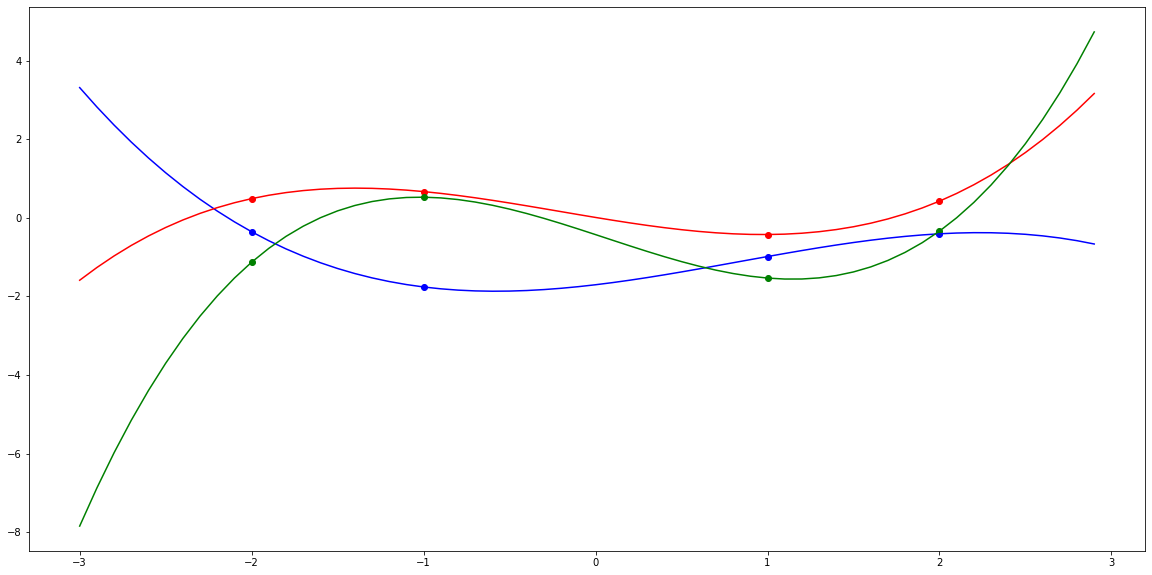

In [13]:
plt.figure(figsize=(20,10))
colors = ['blue', 'red', 'green']
for i in range(3):
    f = np.random.randn(4)
    x = np.array([-2, -1, 1, 2])
    x_fit = np.arange(-3,3,0.1)
    m = np.expand_dims(x,axis=1) ** np.arange(4)
    print(m)
    c = np.linalg.solve(m,f)
    f_fit = c[0] + c[1] * x_fit + c[2] * x_fit**2 + c[3] * x_fit**3
    plt.scatter(x,f, c=colors[i])
    plt.plot(x_fit, f_fit, colors[i])

In [18]:
trainData = next(iter(trainLoader))
inputs_cpu, targets_cpu, gridLR, gridHR, maskLR, maskHR, hrOro, idx = trainData

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

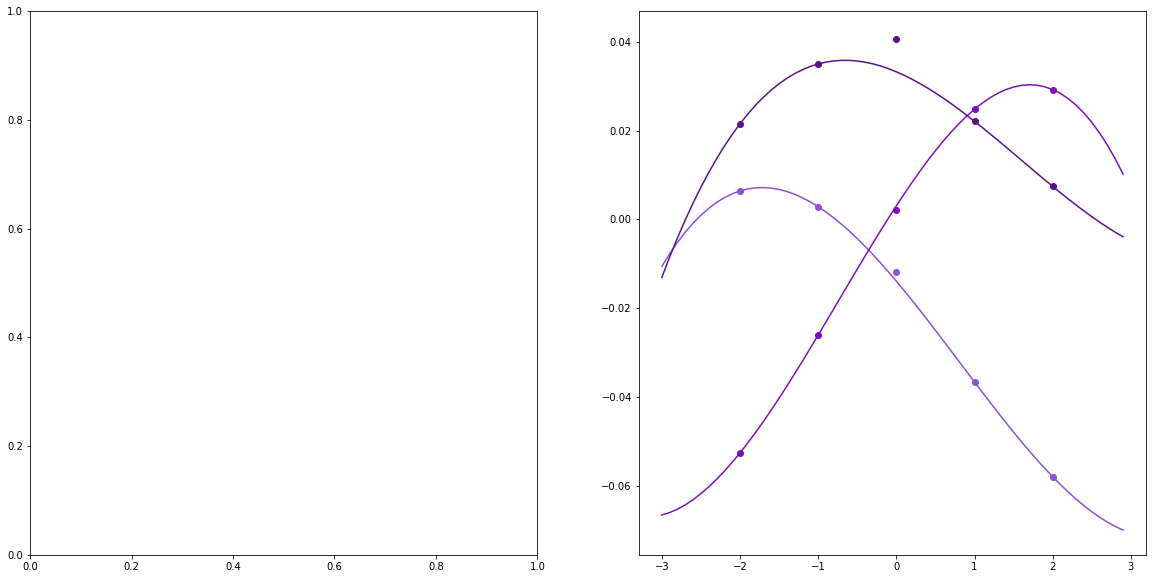

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))
for i in range(3):
    idx1 = np.random.randint(144)
    idx2 = np.random.randint(180)
    f = [target[0, 0, idx1, idx2].data.numpy() for target in targets_cpu]
    t = f.pop(2)
    x = np.array([-2, -1, 1, 2])
    m = np.expand_dims(x,axis=1) ** np.arange(4)
    c = np.linalg.solve(m,f)
    x_fit = np.arange(-3,3,0.1)
    f_fit = c[0] + c[1] * x_fit + c[2] * x_fit**2 + c[3] * x_fit**3
    c = np.random.rand(3)
    plt.scatter(x, f, c=c)
    plt.scatter(0, t, c=c)
    plt.plot(x_fit, f_fit, c=c)

[-2 -1  1  2]
0.0950601895650228


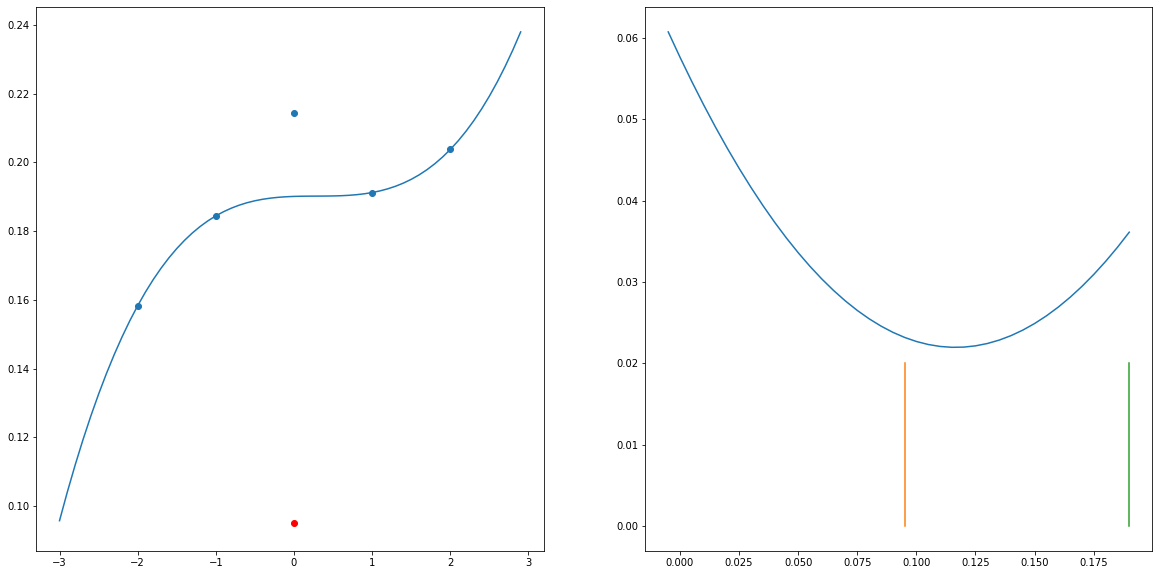

In [77]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))
idx1 = np.random.randint(144)
idx2 = np.random.randint(180)
f_red = [target[0, 0, idx1, idx2].data.numpy() for target in targets_cpu]
x_red = [-2, -1, 0, 1, 2]
f = np.array(f_red)
x = np.array(x_red)
ax[0].scatter(x, f)

f_red.pop(2)
f_red = np.array(f_red)
x_red.pop(2)
x_red = np.array(x_red)
print(x_red)

m_red = np.expand_dims(x_red, axis=1) ** np.arange(4)
minv = np.linalg.inv(m_red)
sig = np.dot(np.transpose(minv), minv)

c_fit = np.linalg.solve(m_red, f_red)

x_fit = np.arange(-3,3,0.1)
f_fit = np.sum((np.expand_dims(x_fit, axis=1) ** np.arange(4)) * c_fit, axis=1)
ax[0].plot(x_fit, f_fit)

c_star = np.sum(np.dot(sig, f_red))/(1+np.sum(sig))
c_prime = np.linalg.solve(m_red, f_red)[0]
ax[0].scatter(0, c_star, c='red')
testvals = c_star + np.arange(-0.1,0.1,0.005)
f = np.transpose(np.tile(f, (len(testvals), 1)))
f[2] = testvals
c = np.linalg.solve(m, f)
print(c_star)
ax[1].plot(testvals, np.sum(np.square(c), axis=0))
ax[1].plot([c_star, c_star], [0,0.02])
ax[1].plot([c_prime, c_prime], [0,0.02])
# x_fit = np.arange(-3,3,0.1)
# f_fit = c[0] + c[1] * x_fit + c[2] * x_fit**2 + c[3] * x_fit**3
# c = np.random.rand(3)

# plt.scatter(0, t, c=c)
# plt.plot(x_fit, f_fit, c=c)

In [67]:
np.expand_dims(np.arange(-3,3,0.1), axis=1) ** np.arange(4)

array([[ 1.00000000e+00, -3.00000000e+00,  9.00000000e+00,
        -2.70000000e+01],
       [ 1.00000000e+00, -2.90000000e+00,  8.41000000e+00,
        -2.43890000e+01],
       [ 1.00000000e+00, -2.80000000e+00,  7.84000000e+00,
        -2.19520000e+01],
       [ 1.00000000e+00, -2.70000000e+00,  7.29000000e+00,
        -1.96830000e+01],
       [ 1.00000000e+00, -2.60000000e+00,  6.76000000e+00,
        -1.75760000e+01],
       [ 1.00000000e+00, -2.50000000e+00,  6.25000000e+00,
        -1.56250000e+01],
       [ 1.00000000e+00, -2.40000000e+00,  5.76000000e+00,
        -1.38240000e+01],
       [ 1.00000000e+00, -2.30000000e+00,  5.29000000e+00,
        -1.21670000e+01],
       [ 1.00000000e+00, -2.20000000e+00,  4.84000000e+00,
        -1.06480000e+01],
       [ 1.00000000e+00, -2.10000000e+00,  4.41000000e+00,
        -9.26100000e+00],
       [ 1.00000000e+00, -2.00000000e+00,  4.00000000e+00,
        -8.00000000e+00],
       [ 1.00000000e+00, -1.90000000e+00,  3.61000000e+00,
      

In [37]:
x = np.array([0, -2, -1, 1, 2])
m = np.expand_dims(x,axis=1) ** np.arange(5)

In [38]:
m

array([[ 1,  0,  0,  0,  0],
       [ 1, -2,  4, -8, 16],
       [ 1, -1,  1, -1,  1],
       [ 1,  1,  1,  1,  1],
       [ 1,  2,  4,  8, 16]])

In [42]:
minv = np.linalg.inv(m)

In [43]:
np.dot(np.transpose(minv), minv)

array([[ 2.62500000e+00,  6.25000000e-02, -8.75000000e-01,
        -8.75000000e-01,  6.25000000e-02],
       [ 6.25000000e-02,  1.73611111e-02, -1.04166667e-01,
         3.47222222e-02, -1.04166667e-02],
       [-8.75000000e-01, -1.04166667e-01,  9.44444444e-01,
        -8.13392563e-17,  3.47222222e-02],
       [-8.75000000e-01,  3.47222222e-02, -8.13392563e-17,
         9.44444444e-01, -1.04166667e-01],
       [ 6.25000000e-02, -1.04166667e-02,  3.47222222e-02,
        -1.04166667e-01,  1.73611111e-02]])

In [44]:
minv

array([[ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [-0.        ,  0.08333333, -0.66666667,  0.66666667, -0.08333333],
       [-1.25      , -0.04166667,  0.66666667,  0.66666667, -0.04166667],
       [-0.        , -0.08333333,  0.16666667, -0.16666667,  0.08333333],
       [ 0.25      ,  0.04166667, -0.16666667, -0.16666667,  0.04166667]])

In [45]:
np.linalg.inv(m[1:,1:])

array([[ 0.08333333, -0.66666667,  0.66666667, -0.08333333],
       [-0.04166667,  0.66666667,  0.66666667, -0.04166667],
       [-0.08333333,  0.16666667, -0.16666667,  0.08333333],
       [ 0.04166667, -0.16666667, -0.16666667,  0.04166667]])